## Interevent times for creating reading sessions

When trying to construct reading sessions we have to sessionize sequences of pageviews by the same user into sessions. A typical way is to take the time between two consecutive pageviews (the interevent time) and consider the start of a new session if the interevent time is above a threshold (say 30mins). In [1], the authors looked at the distribution of interevent times in wikipedia pageviews and claimed that 1 hour constitutes an optimal threshold; since then this has become a standard in defining reading sessions. Specifically, the authors looked at the distribution of interevent times and found that this shows a bimodal distribution (Fig. 1); fitting a mixture of gaussian the authors find that the two peaks are best separated by the threshold of 1 hour.

[1] Halfaker et al 2015, https://dl.acm.org/doi/10.1145/2736277.2741117


#### Here, we revisit the question of how to construct reading sessions.

We look at the distribution of interevent times. We do find a bimodal distribution with 2 peaks at around 1 minute and 1 day. The optimal threshold of 1 hour is not immediately obvious.

We also consider an alternative criterion by looking at the probability that two consecutive pageviews are about the same topic. The hypothesis is that 2 consecutive pageviews in the same session are more likely to be about the same topic than 2 consecutive pageviews in different sessions. We find that the probability that 2 consectuive pageviews are about the same topic decreases systematically with the interevent time (linearly with the log of the interevent time). This suggests that this criterion does not provide an optimal cutoff.


#### These results suggest that there is some ambiguity in how to construct reading sessions

In [1]:
import numpy as np
import matplotlib as mpl
import pylab as plt
%matplotlib inline 

mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [2]:
import os, sys
import datetime
import calendar
import time
import string
import random
import pandas as pd
import findspark
findspark.init('/usr/lib/spark2')
from pyspark.sql import SparkSession
from pyspark.sql import functions as F, types as T, Window
import wmfdata.spark as wmfspark

## defining the spark session
spark_config = {}
## regular
# spark_config = {
#     "spark.driver.memory": "2g",
#     "spark.dynamicAllocation.maxExecutors": 64,
#     "spark.executor.memory": "8g",
#     "spark.executor.cores": 4,
#     "spark.sql.shuffle.partitions": 256
# }
spark_config = {
    "spark.driver.memory": "4g",
    "spark.dynamicAllocation.maxExecutors": 128,
    "spark.executor.memory": "8g",
    "spark.executor.cores": 4,
    "spark.sql.shuffle.partitions": 512
}

os.environ['PYSPARK_DRIVER_PYTHON'] = 'notebook'
os.environ['PYSPARK_PYTHON'] = '/usr/bin/python3.5'

spark = wmfspark.get_session(
    app_name='Pyspark notebook', 
    extra_settings=spark_config
)
spark

You are using wmfdata v1.0.1, but v1.0.4 is available.

To update, run `pip install --upgrade git+https://github.com/neilpquinn/wmfdata/wmfdata.git@release`.

To see the changes, refer to https://github.com/neilpquinn/wmfdata/blob/release/CHANGELOG.md


## Load the topics for each page in Wikipedia

The topics for wikipedia-pages are taken from here: https://figshare.com/articles/Topics_for_each_Wikipedia_Article_across_Languages/12127434

Copy to hive via:

hdfs dfs -copyFromLocal -f topicsForAllWikipediaPages.csv /user/mgerlach/topicsForAllWikipediaPages.csv

In [3]:
filename_read = '/user/mgerlach/topicsForAllWikipediaPages.csv'
df_topics = spark.read.csv(filename_read,header=True)
df_topics.printSchema()

root
 |-- Qid: string (nullable = true)
 |-- topic: string (nullable = true)
 |-- probability: string (nullable = true)
 |-- page_id: string (nullable = true)
 |-- page_title: string (nullable = true)
 |-- wiki_db: string (nullable = true)



In [4]:
## only keep qids (get rid of page-id, page-title, wiki_db)
df_topics_qid = (
    df_topics
    .select(
        'Qid',
        'topic',
        'probability'
    )
    .distinct()
)

In [5]:
df_topics_qid_agg = (
    df_topics_qid
    .where(F.col('probability')>0.5)
    .groupBy('Qid')
    .agg(
        F.array_sort(
            F.collect_list(
                F.struct(
                    F.col('topic'),
                    F.col('probability'),
                )
                
            )
        ).alias('topics')
    )
    .withColumnRenamed('Qid','item_id')
)

## Get the reading sessions

We get reading sessions for one week in English Wikipedia from the [pageview-actor table](https://wikitech.wikimedia.org/wiki/Analytics/Data_Lake/Traffic/Pageview_actor)

In [40]:
## wiki_db ## seleecting wikidata gets pageviews from all wikis
## select a specific wiki_db for testing to reduce processing time, e.g. simplewiki
wiki_db = 'enwiki'

## timewindow
date_start = datetime.datetime(2020, 7, 1, 0)
# date_end = datetime.datetime(2020, 7, 1, 1)
# date_end = datetime.datetime(2020, 7, 2, 0)
date_end = datetime.datetime(2020, 7, 8, 0)


ts_start = calendar.timegm(date_start.timetuple())
ts_end = calendar.timegm(date_end.timetuple())
row_timestamp = F.unix_timestamp(F.concat(
    F.col('year'), F.lit('-'), F.col('month'), F.lit('-'), F.col('day'), 
    F.lit(' '), F.col('hour'), F.lit(':00:00')))

In [41]:
## filter pageviews from actor with more than 500 pageviews
## the aim is to filter automated traffic that is not tagged as spider
w_p = Window.partitionBy(F.col('actor_signature_per_project_family'), F.col('year'), F.col('month'), F.col('day'))
n_p_max = 500 ## maximum number of pageviews/user/day
n_p_min = 1 ## minimum number of pageviews/user/day

In [42]:
df_actor = (
    spark.read.table('wmf.pageview_actor')
    .where(row_timestamp >= ts_start)
    .where(row_timestamp < ts_end)
    .where(F.col('is_pageview')==True)
    ## agent-type user to filter spiders
    ## https://meta.wikimedia.org/wiki/Research:Page_view/Tags#Spider
    .where(F.col('agent_type') == "user")
    ## user: desktop/mobile/mobile app; isaac filters != mobile app
    .where(F.col('access_method') != "mobile app")
    ## only wikis
    .where(F.col('normalized_host.project_family')=='wikipedia')
    ## only namespace 0
    .where( F.col('namespace_id') == 0 )
    .withColumn('wiki_db', F.concat(F.col('normalized_host.project'),F.lit('wiki')) )
)
## filter only specific wiki (or all if wiki_db=='wikidata')
if wiki_db == 'wikidata':
    pass
else:
    df_actor = df_actor.where(F.col('wiki_db')==wiki_db)
    
## filter maximum and minimum pageviews per user
## n_p is the number of pageviews per actor per day (across projects)
df_actor = (
    df_actor
    .withColumn('n_p', F.sum(F.lit(1)).over(w_p) )
    .where(F.col('n_p') >= n_p_min)
    .where(F.col('n_p') <= n_p_max)    
)
# df_tmp=df_actor.limit(10).toPandas()
# df_tmp.head()

In [43]:
## join the wikidata-item to each pageview
## we keep only pageviews for which we have a correpsionding wikidata-item id

## table with mapping wikidata-ids to page-ids
## partition wikidb and page-id ordered by snapshot
w_wd = Window.partitionBy(F.col('wiki_db'),F.col('page_id')).orderBy(F.col('snapshot').desc())
df_wd = (
    spark.read.table('wmf.wikidata_item_page_link')
    ## snapshot: this is a partition!
    .where(F.col('snapshot') >= '2020-01-06') ## resolve issues with non-mathcing wikidata-items
    ## only wikis (enwiki, ... not: wikisource)
    .where(F.col('wiki_db').endswith('wiki'))
)
## filter only specific wiki (or all if wiki_db=='wikidata')
if wiki_db == 'wikidata':
    pass
else:
    df_wd = df_wd.where(F.col('wiki_db')==wiki_db)
## get the most recent wikidata-item for each pid+wikidb
df_wd = (
    df_wd
    .withColumn('item_id_latest',F.first(F.col('item_id')).over(w_wd))
    .select(
        'wiki_db',
        'page_id',
        F.col('item_id_latest').alias('item_id')
    )
    .drop_duplicates()
)
df_actor_wd = (
    df_actor
    .join(
        df_wd,
        on = ['page_id','wiki_db'],
        how='inner'
    )
)

In [44]:
## join in the topics
df_actor_wd = (
    df_actor_wd
    .join(
        df_topics_qid_agg,
        on = ['item_id'],
        how='left'
    )
    
)

In [45]:
## aggregate all pageviews with same actor-signature across wikis
df_actor_wd_agg = (
    df_actor_wd
    .groupby('actor_signature_per_project_family')
    .agg(
         F.first(F.col('access_method')).alias('access_method'), ## this could change along a session
         F.first(F.col('geocoded_data')).alias('geocoded_data'),
#              F.first(F.col('n_p_by_user')).alias('session_length'),
         F.array_sort(
             F.collect_list(
                 F.struct(
                     F.col('ts'),
                     F.col('page_id'),
                     F.col('pageview_info.page_title').alias('page_title'),
                     F.col('wiki_db'),
                     F.col('item_id').alias('qid'),
                     F.col('topics')
                 )
             )
         ).alias('session')
     )
)

## Calculate the time-difference between 2 consecutive pageviews (dwelling times)

In [46]:
df = df_actor_wd_agg.rdd.map(lambda x: x['session'])

In [47]:
def dwelling_times(requests):
    n = len(requests)
    list_ts = []
    if n>1:
        i=0
        for i in range(n-1):
            r1 = requests[i]
            r2 = requests[i+1]
            t1 = r1.ts
            t2 = r2.ts
            if t1!=None and t2!=None:
                ts = int((r2.ts-r1.ts).total_seconds())
            else:
                ts=np.nan
            topics1 = r1.topics
            if topics1!=None:
                t1 = [h['topic'] for h in topics1]
            else:
                t1 = []
            topics2 = r2.topics
            if topics2!=None:
                t2 = [h['topic'] for h in topics2]
            else:
                t2 = []
                
            t_remains = 0 ## overlap in topics
            if len(set(t1).intersection(set(t2)))>0:
                t_remains=1
            list_ts.append(
                T.Row(
                    dwelling_times=ts,
                    t_from=t1,
                    t_to=t2,
                    t_remains=t_remains
                )
            )
    return list_ts

df_ts = df.flatMap(dwelling_times)        
# df_ts.take(10)

In [48]:
df_dt_counts = (
    df_ts.toDF()
    .groupBy('dwelling_times')
    .agg(
        F.count(F.col('dwelling_times')).alias('c_dt'),
        F.sum(F.col('t_remains')).alias('c_tr')
    )
    .orderBy('dwelling_times')
)
df_dt_counts = df_dt_counts.toPandas()
df_dt_counts.head()

,dwelling_times,c_dt,c_tr
0,NaN,0,14
1,0.0,15117468,11525021
2,1.0,14453421,10832217
3,2.0,21119648,15385914
4,3.0,22688743,16261560


In [53]:
df_dt_counts=df_dt_counts.dropna()

In [59]:
df_dt_counts.sum(axis=0)

dwelling_times    1.773619e+11
c_dt              1.185891e+09
c_tr              7.397490e+08
dtype: float64

#### Cumulative distribution of dwelling times

This is the probability that the dwelling time between 2 consecutive pageviews is larger than x (the distribution starts at 1 and decays monotonically to 0).

- we plot this in a log-log plot since the dwelling times span many orders of magnitude (from 1 sec to 1 day).
- we see in this plot that the distribution is a linear line (from around 10 secs to 10,000 secs). This suggests that there is no characteristics time which would indicate a best threshold.

Text(0.5, 1.0, 'Cumulative distribution dwelling times')

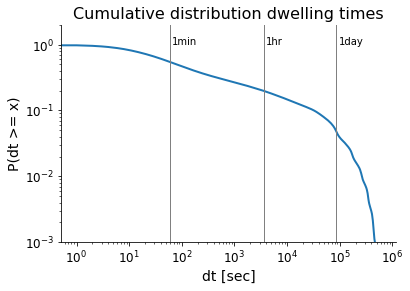

In [54]:
## cumulative distribution

dt_arr = np.array(df_dt_counts['dwelling_times'])
n_arr = np.array(df_dt_counts['c_dt'])
p_arr = n_arr/np.sum(n_arr)
p_arr_cumsum = 1 - np.cumsum(p_arr)


fig, ax = plt.subplots(1, 1 ,figsize=(6,4 ))
x = dt_arr
y = p_arr_cumsum
ax.plot(x,y,lw=2)
ax.set_xscale('log')
ax.set_yscale('log')

y_min,y_max = 0.001,2.
ax.set_ylim(y_min,y_max)
ax.set_xlabel('dt [sec]')
ax.set_ylabel('P(dt >= x)')


list_dt_map = [60,60*60,60*60*24]
list_dt_labels = ['1min','1hr','1day']
for i_dt_map,dt_map in enumerate(list_dt_map):
    ax.plot( [dt_map,dt_map],[y_min,y_max], lw=1, color=str(0.5),ls='-'  )
    ax.text(1.1*dt_map,1.0,list_dt_labels[i_dt_map])
ax.set_title('Cumulative distribution dwelling times')

#### Log-binned histogram of dwelling times

We count the fraction of events that fall in a given bin of dwelling times (number of events in the bin dividied by the total number of events). We systematically increase the size of the bin in order to account for the fact that we have fewer and fewer events for larger dwelling times, i.e. the bins are [1], [2,3], [4,5,6,7], [8-15], [16-31], etc.


- we now see two peaks at around 1 minute and 1 day

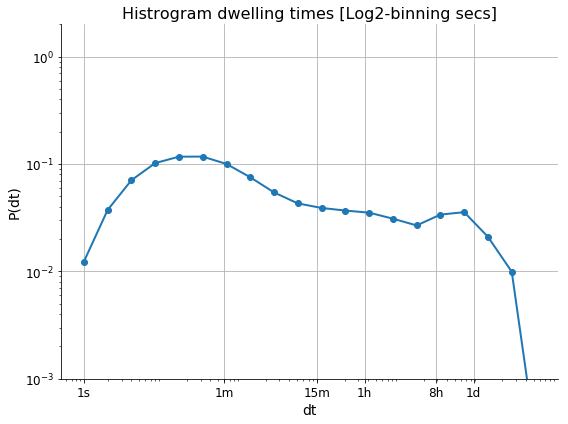

In [55]:
## log-binned histogram

dtmax = np.max(dt_arr)
dtmax2 = int(np.log2(dtmax))+1
bins = np.logspace( 0,dtmax2,dtmax2+1,base=2  ).astype(int)

fig, ax = plt.subplots(1, 1 ,figsize=(8,6 ))
dt_arr_bins = bins[:-1]
n_arr_bins = np.array([])
for i_bin in range(len(bins)-1):
    x1 = bins[i_bin]
    x2 = bins[i_bin+1]
    ind_sel = np.where( (dt_arr>=x1)&(dt_arr<x2) )[0]
    n_sel = np.sum(n_arr[ind_sel])
    n_arr_bins=np.append(n_arr_bins,n_sel)
x = dt_arr_bins
y = n_arr_bins/np.sum(n_arr_bins)
ax.plot(x,y,lw=2,marker='o')
    
  
    
ax.set_xscale('log')
ax.set_yscale('log')
y_min,y_max = 0.001,2.
ax.set_ylim(y_min,y_max)
ax.set_xlabel('dt')
ax.set_ylabel('P(dt)')
list_dt_map = [1,60,60*15,60*60,60*60*8,60*60*24]
list_dt_labels = ['1s','1m','15m','1h','8h','1d']
ax.set_xticks(list_dt_map)
ax.set_xticklabels(list_dt_labels)
ax.grid(True)

ax.set_title('Histrogram dwelling times [Log2-binning secs]')
# ax.legend(loc='lower left')
plt.tight_layout()

## 2 consecutive pageviews with the same topic

We show the probability that 2 consectuive pageviews have the same topic.
We plot the probability as a function of the dwelling time.

As expected, the probability decreases (i.e. it is less likely that 2 pageviews have the same topic the further they are apart in time).

The linear decay (with logarithmic x-axis) does not suggest that there is a charactersitic time at which to impose a cutoff.



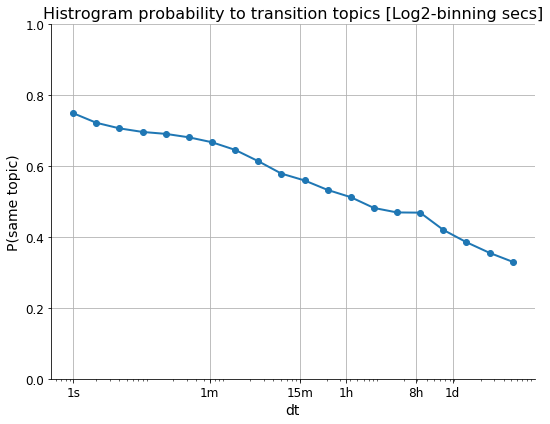

In [57]:
dt_arr = np.array(df_dt_counts['dwelling_times'])
n_arr = np.array(df_dt_counts['c_dt'])
n_tr_arr = np.array(df_dt_counts['c_tr'])


dtmax = np.max(dt_arr)
dtmax2 = int(np.log2(dtmax))+1
bins = np.logspace( 0,dtmax2,dtmax2+1,base=2  ).astype(int)

fig, ax = plt.subplots(1, 1 ,figsize=(8,6 ))
dt_arr_bins = bins[:-1]
p_arr_bins = np.array([])
for i_bin in range(len(bins)-1):
    x1 = bins[i_bin]
    x2 = bins[i_bin+1]
    ind_sel = np.where( (dt_arr>=x1)&(dt_arr<x2) )[0]
    n_sel = np.sum(n_arr[ind_sel])
    n_tr_sel = np.sum(n_tr_arr[ind_sel])
    p_sel = n_tr_sel/n_sel
    p_arr_bins=np.append(p_arr_bins,p_sel)
x = dt_arr_bins
y = p_arr_bins
ax.plot(x,y,lw=2,marker='o')
    
  
    
ax.set_xscale('log')
# ax.set_yscale('log')
y_min,y_max = 0.0,1.
ax.set_ylim(y_min,y_max)
ax.set_xlabel('dt')
ax.set_ylabel('P(same topic)')
list_dt_map = [1,60,60*15,60*60,60*60*8,60*60*24]
list_dt_labels = ['1s','1m','15m','1h','8h','1d']
ax.set_xticks(list_dt_map)
ax.set_xticklabels(list_dt_labels)
ax.grid(True)

ax.set_title('Histrogram probability to transition topics [Log2-binning secs]')
# ax.legend(loc='lower left')
plt.tight_layout()